## Analysis of a coarse-grained trajectory

#### In this notebook we will learn how to analyze a coarse-grained trajectory of an amphiphilic molecule that self-assembles to form a fiber. 

We want to understand how these molecules interact with each other to form these fibers and how the structure changes over time.

We will calculate: 
- the density distribution and radial distribution functions of the different residues forming the hydrophobic/hydrophilic portion of the fiber
- the order parameter, defined as the angle between the peptides and the long axis of the fiber
- the eccentricity of the fiber

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import math
import nglview as nv
import MDAnalysis as mda
from MDAnalysis.lib import distances 
from MDAnalysis.analysis.lineardensity import LinearDensity

import seaborn as sns

from MDAnalysis.analysis import rdf
import MDAnalysisData as data

## 1. Load the trajectory

Load the MD trajectory (dcd) and topology file (psf)

In [2]:
CG_fiber = data.datasets.fetch_CG_fiber()

u = mda.Universe(CG_fiber['topology'], CG_fiber['trajectory'])

The system we're studying has several components: the amphiphilic molecules (126 polymer chains), water and ions. Because we want to know how each component behaves during self-assembly, we want to separate our system into polymer and water

In [5]:
poly = u.atoms.select_atoms('not name W CL NA')

In [6]:
poly

<AtomGroup with 1638 atoms>

In [7]:
w = u.atoms.select_atoms('name W')

We can use nglview to see our trajectory:

In [8]:
POLY = nv.show_mdanalysis(poly)
POLY

/anaconda/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:906: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/anaconda/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:906: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/anaconda/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:906: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/anaconda/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:906: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


A Jupyter Widget

Each polymer chain has 4 different regions. The hydrophobic region is made up of the AAA residue, while BBB, CCC and DDD residues are hydrophilic.

Make 4 atomselections grouping the same residue names all together:

In [9]:
AAA=poly.atoms.select_atoms('resname AAA')
BBB=poly.atoms.select_atoms('resname BBB')
CCC=poly.atoms.select_atoms('resname CCC')
DDD=poly.atoms.select_atoms('resname DDD')

## 2. Density profile calculation

One way to understand how the polymer self-assembles is to look at the density distributions of different residues. The linear density function tells us where each residue is located with respect to the center of the box. We only look along the xy plane since the long axis of the fiber lies along the z direction and we want to know if the polymers are ordered along the radial direction as they assemble.

The `LinearDensity` function takes an `atomgroup` as input, and optionally a binsize.

In [11]:
a_dens=LinearDensity(AAA, binsize=1)

We first define an object using this function, then we run the actual linear density calculation by using the `.run()` function. We can define the frames (`start`, `stop`, `step`) over which the density is calculated. The default is the entire trajectory.

In [15]:
ad=a_dens.run()

The density calculation return the dictionary `.results`.
The keys 'x', 'y', and 'z' denote the three directions. 

Under these keys, 'pos' indicates the mass-weighted density:

In [18]:
ad.results['x']['pos']

array([4.09914502e-02, 4.04422815e-02, 4.05882007e-02, 4.02707279e-02,
       4.00064960e-02, 3.89347790e-02, 3.81765909e-02, 3.70536050e-02,
       3.57432905e-02, 3.32044944e-02, 3.10689479e-02, 2.83053575e-02,
       2.49728796e-02, 2.10192594e-02, 1.72815600e-02, 1.33377992e-02,
       9.88700844e-03, 6.93313157e-03, 4.56983288e-03, 3.00711765e-03,
       1.95018974e-03, 1.22157992e-03, 8.47908582e-04, 5.96493828e-04,
       4.23954291e-04, 3.12543047e-04, 2.78035140e-04, 1.97188042e-04,
       1.67609836e-04, 1.03523722e-04, 1.15355005e-04, 8.38049180e-05,
       7.98611571e-05, 6.21142333e-05, 6.01423529e-05, 5.91564127e-05,
       4.33813693e-05, 4.33813693e-05, 4.23954291e-05, 2.95782063e-05,
       2.56344455e-05, 2.36625651e-05, 2.66203857e-05, 2.36625651e-05,
       1.87328640e-05, 1.28172228e-05, 6.90158148e-06, 1.08453423e-05,
       2.95782063e-06, 0.00000000e+00, 5.91564127e-06, 3.94376085e-06,
       9.85940212e-07, 3.94376085e-06, 3.94376085e-06, 9.85940212e-07,
      

Let's write a function to calculate the linear density of each residue (AAA, BBB, etc) over a certain interval in the trajectory. We're interested in the xy plane, due to the cylindrical symmetry of our system; we can therefore average the results along x and y.

In [21]:
def fiber_density(res,first,last):
    dens = LinearDensity(res, binsize=0.5)
    dens.run(start=first, stop=last)
    dens_xy = 0.5*(dens.results['x']['pos']+ dens.results['y']['pos'])
    return dens_xy

Let's run this function over the first 5 frames of the trajectory, where the polymers are distributed randomly:

In [22]:
Adens=fiber_density(AAA,0,5)
Bdens=fiber_density(BBB,0,5)
Cdens=fiber_density(CCC,0,5)
Ddens=fiber_density(DDD,0,5)

Plot the results for each residue name:

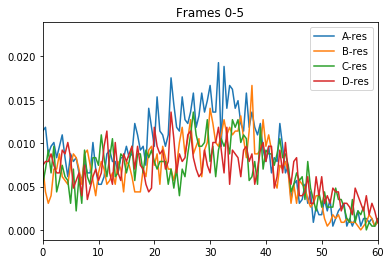

In [24]:
x = np.arange(0,AAA.dimensions[1], 0.5)
fig, ax = plt.subplots()
ax.plot(x, Adens, label='A-res')
ax.plot(x, Bdens, label='B-res')
ax.plot(x, Cdens, label='C-res')
ax.plot(x, Ddens, label='D-res')
plt.title('Frames 0-5')
plt.legend()
plt.xlim([0,60])
plt.show()

To see how the density profile changes over time, we can repeat the same calculation for different time intervals.

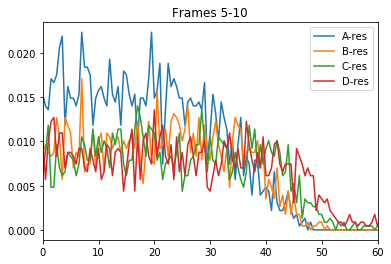

In [26]:
Adens=fiber_density(AAA,5,10)
Bdens=fiber_density(BBB,5,10)
Cdens=fiber_density(CCC,5,10)
Ddens=fiber_density(DDD,5,10)
x = np.arange(0,AAA.dimensions[1], 0.5)
fig, ax = plt.subplots()
ax.plot(x, Adens, label='A-res')
ax.plot(x, Bdens, label='B-res')
ax.plot(x, Cdens, label='C-res')
ax.plot(x, Ddens, label='D-res')
plt.legend()
plt.title('Frames 5-10')
plt.xlim([0,60])
plt.show()


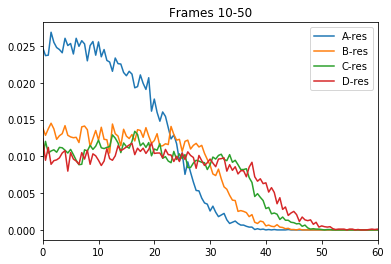

In [27]:
Adens=fiber_density(AAA,10,50)
Bdens=fiber_density(BBB,10,50)
Cdens=fiber_density(CCC,10,50)
Ddens=fiber_density(DDD,10,50)
x = np.arange(0,AAA.dimensions[1], 0.5)
fig, ax = plt.subplots()
ax.plot(x, Adens, label='A-res')
ax.plot(x, Bdens, label='B-res')
ax.plot(x, Cdens, label='C-res')
ax.plot(x, Ddens, label='D-res')
plt.title('Frames 10-50')
plt.legend()
plt.xlim([0,60])
plt.show()


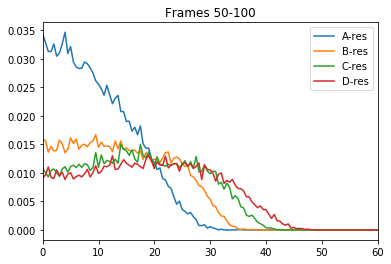

In [29]:
Adens=fiber_density(AAA,50,100)
Bdens=fiber_density(BBB,50,100)
Cdens=fiber_density(CCC,50,100)
Ddens=fiber_density(DDD,50,100)
x = np.arange(0,AAA.dimensions[1], 0.5)
fig, ax = plt.subplots()
ax.plot(x, Adens, label='A-res')
ax.plot(x, Bdens, label='B-res')
ax.plot(x, Cdens, label='C-res')
ax.plot(x, Ddens, label='D-res')
plt.legend()
plt.title('Frames 50-100')
plt.xlim([0,60])
plt.show()


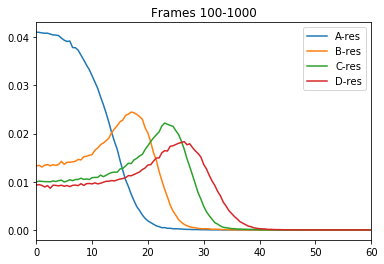

In [30]:
Adens=fiber_density(AAA,100,1000)
Bdens=fiber_density(BBB,100,1000)
Cdens=fiber_density(CCC,100,1000)
Ddens=fiber_density(DDD,100,1000)
x = np.arange(0,AAA.dimensions[1], 0.5)
fig, ax = plt.subplots()
ax.plot(x, Adens, label='A-res')
ax.plot(x, Bdens, label='B-res')
ax.plot(x, Cdens, label='C-res')
ax.plot(x, Ddens, label='D-res')
plt.legend()
plt.title('Frames 100-1000')

plt.xlim([0,60])
plt.show()


We can also see how the distribution of water molecules with respect to the center changes over time:

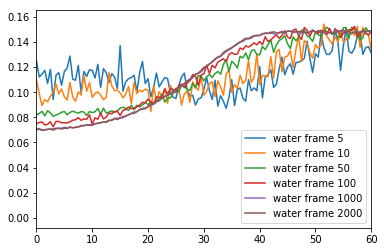

In [43]:
Wdens1=fiber_density(w,0,5)
Wdens2=fiber_density(w,5,10)
Wdens3=fiber_density(w,10,50)
Wdens4=fiber_density(w,50,100)
Wdens5=fiber_density(w,100,1000)
Wdens6=fiber_density(w,1000,2000)

fig, ax = plt.subplots()
ax.plot(x, Wdens1, label='water frame 5')
ax.plot(x, Wdens2, label='water frame 10')
ax.plot(x, Wdens3, label='water frame 50')
ax.plot(x, Wdens4, label='water frame 100')
ax.plot(x, Wdens5, label='water frame 1000')
ax.plot(x, Wdens6, label='water frame 2000')
plt.legend()
plt.xlim([0,60])
plt.show()


## 3. Radial distribution function (RDF) calculations
While the density profile tells us where we can find each component of our system in our simulation box, radial distribution function describes the probability of finding an atom/molecule within a certain distance of another. 

First, we want to see how each polymer chain is distributed with respect to other polymer chains. For this, we choose the first bead (named T4) in the chain, which is found in the core of the fiber when self-assembled.

In [36]:
T4=AAA.atoms.select_atoms("name T4")

Use the `rdf.InterRDF` function to calculate the radial distribution function:

In [39]:
T4_rdf=rdf.InterRDF(T4, T4, range=(0,40), nbins=40, exclusion_block=(1,1))

As before, we need to `.run()`  the radial distribution function, and optionally select an interval of frames.

In [43]:
RDF=T4_rdf.run()

This returns  a `.rdf` numpy array:

In [44]:
RDF.rdf

array([ 0.        ,  0.        ,  0.        ,  0.        , 23.85640451,
       56.30527414, 21.46554394, 16.30642503, 20.97583248, 25.4907291 ,
       21.92020662, 16.41546636, 15.42345809, 15.74027283, 14.63611572,
       12.40410158, 10.81556918, 10.10513786,  9.36574753,  8.30463839,
        7.30555749,  6.57912651,  6.04226403,  5.47444891,  4.88485584,
        4.41558478,  4.04488789,  3.71620519,  3.39400133,  3.09837004,
        2.86529883,  2.6559541 ,  2.47011885,  2.08094215,  1.36323976,
        0.87379756,  0.55382314,  0.3457333 ,  0.21460703,  0.13298925])

Now let's calculate the rdf for different intervals in the trajectory:

In [46]:
A_rdf1=rdf.InterRDF(T4, T4, range=(0,40), nbins=40, exclusion_block=(1,1))
A_rdf2=rdf.InterRDF(T4, T4, range=(0,40), nbins=40, exclusion_block=(1,1))
A_rdf3=rdf.InterRDF(T4, T4, range=(0,40), nbins=40, exclusion_block=(1,1))
A_rdf4=rdf.InterRDF(T4, T4, range=(0,40), nbins=40, exclusion_block=(1,1))
A_rdf5=rdf.InterRDF(T4, T4, range=(0,40), nbins=40, exclusion_block=(1,1))

A_rdf1.run(start=0, stop=5)
A_rdf2.run(start=5, stop=10)
A_rdf3.run(start=10, stop=50)
A_rdf4.run(start=50, stop=100)
A_rdf5.run(start=100, stop=1000)

Plot the results:

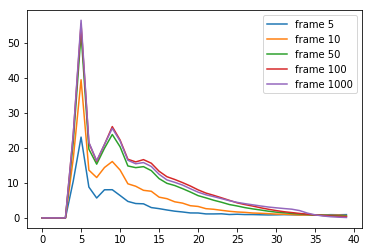

In [48]:
fig, ax = plt.subplots()
ax.plot(A_rdf1.rdf, label='frame 5')
ax.plot(A_rdf2.rdf, label='frame 10')
ax.plot(A_rdf3.rdf, label='frame 50')
ax.plot(A_rdf4.rdf, label='frame 100')
ax.plot(A_rdf5.rdf, label='frame 1000')
plt.legend()
plt.show()

We can also calculate distribution of water from the core of the fiber.

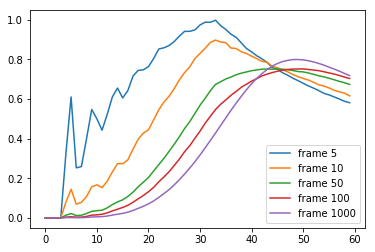

In [49]:
Aw_rdf1=rdf.InterRDF(T4, w, range=(0,60), nbins=60, start=0, stop=5)
Aw_rdf2=rdf.InterRDF(T4, w, range=(0,60), nbins=60, start=5, stop=10)
Aw_rdf3=rdf.InterRDF(T4, w, range=(0,60), nbins=60, start=10, stop=50)
Aw_rdf4=rdf.InterRDF(T4, w, range=(0,60), nbins=60, start=50, stop=100)
Aw_rdf5=rdf.InterRDF(T4, w, range=(0,60), nbins=60, start=100, stop=1000)

Aw_rdf1.run()
Aw_rdf2.run()
Aw_rdf3.run()
Aw_rdf4.run()
Aw_rdf5.run()
fig, ax = plt.subplots()
ax.plot(Aw_rdf1.rdf, label='frame 5')
ax.plot(Aw_rdf2.rdf, label='frame 10')
ax.plot(Aw_rdf3.rdf, label='frame 50')
ax.plot(Aw_rdf4.rdf, label='frame 100')
ax.plot(Aw_rdf5.rdf, label='frame 1000')
plt.legend()
plt.show()

## 4. Order parameter 
We want to know more about how these polymer chains are arranged when they pack to form a fiber. 

One parameter we can calculate is the angle each polymer chain makes with the long axis of the fiber, which in our system corresponds with the Z axis.

Define the z axis vector:

In [49]:
vec = np.array([0, 0, 1])

For each  fragment (polymers chain), calculate the principal vector along the chain.
This can be simply done by using the built-in function `principal_axes()`, and taking the last element, which corresponds to the smallest moment of inertia (therefore should lie along the polymer chain).


In [54]:
for f in poly.atoms.fragments: 
    print(f.principal_axes()[-1])

[-0.82596701 -0.42225612  0.37346789]
[-0.95248518  0.21536807 -0.21538007]
[-0.8374357   0.41077844 -0.36050314]
[-0.90038043 -0.41561848  0.12874917]
[-0.42140042 -0.86601461  0.26914752]
[0.59616055 0.77945033 0.19248318]
[ 0.69304631  0.01910322 -0.72063991]
[-0.86743589  0.4716159   0.15853523]
[-0.28422247 -0.88886724 -0.35935027]
[-0.92721707 -0.36287002 -0.09270298]
[-0.93745064 -0.33432472  0.09702209]
[-0.20759001 -0.78954557 -0.57751552]
[ 0.77024011 -0.61955785  0.15125554]
[ 0.53726941 -0.84155222 -0.05595935]
[-0.75711004  0.40424496 -0.51319625]
[ 0.8115327  -0.20252912 -0.54808451]
[-0.66266357  0.73249503  0.15597442]
[-0.24513139 -0.87625144 -0.41484215]
[ 0.91680248 -0.39363671  0.06725586]
[-0.90488018 -0.11229364  0.41058739]
[ 0.08314672  0.6968154  -0.71241486]
[-0.80877138 -0.52238613 -0.27018805]
[ 0.22857143  0.96365113 -0.138317  ]
[-0.84781563 -0.3936929  -0.35526687]
[-0.59074984  0.61654228 -0.52047117]
[-0.93331989 -0.21473555  0.28775445]
[-0.53671648 -0

The order parameter is then calculated by taking the dot product between the polymer axis and the Z axis:

In [55]:
angle = []
for f in poly.atoms.fragments:   
    pa = f.principal_axes()[-1]  
    costheta = np.dot(pa, vec) 
    angle.append(np.rad2deg(np.arccos(costheta)))

In [56]:
angle

[68.07034939500966,
 102.43782601894554,
 111.13109907703502,
 82.60268227754553,
 74.38645431873171,
 78.90226477848312,
 136.1073376503013,
 80.8781140010077,
 111.06029939619509,
 95.31912704447117,
 84.43228507774327,
 125.2759864546925,
 81.30030586821199,
 93.2079100317364,
 120.87696617994864,
 123.23570134862044,
 81.02668599101328,
 114.50937642775834,
 86.14361219833482,
 65.7582608984302,
 135.43173582440795,
 105.67545723951525,
 97.95046981063015,
 110.80980120022724,
 121.36386226192447,
 73.27643405989016,
 57.92112645740926,
 85.71289670616488,
 64.77624365633436,
 113.25386143378543,
 38.11992445647627,
 137.68751831396062,
 97.61934247394124,
 54.64455837986879,
 87.43250587734758,
 104.95607965686804,
 105.13779118823898,
 156.66743116355238,
 107.66982726832975,
 128.74954646545942,
 154.382091153648,
 91.31519061975365,
 126.38066356192455,
 152.25371448784233,
 116.43626220544522,
 150.43582686571796,
 151.71635652301765,
 104.2893326522856,
 85.05315335047378,
 8

We can then write a function to do this, by iterating over an interval in the trajectory:

In [57]:
def order_parameter(u,start,stop):
    vec = np.array([0, 0, 1])  # Use the z-axis as reference since fiber is formed along z
    poly= u.atoms.select_atoms('not name W CL NA') 
    angle = []
    for ts in u.trajectory[start:stop]:
        for f in poly.atoms.fragments:   # loop over each polymer chain based on segment names in psf file
            pa = f.principal_axes()[-1]  # calculate the principal axis to fit a vector to each polymer chain
            costheta = np.dot(pa, vec)   # calculate the angle by taking the dot product
            angle.append(np.rad2deg(np.arccos(costheta)))
    return angle 

Now run the function over different intervals, just like before with the density profile.

In [58]:
op1=order_parameter(u,0,50)

In [59]:
op2=order_parameter(u,50,100)

In [60]:
op3=order_parameter(u,100,150)

In [61]:
op4=order_parameter(u,150,200)

In [62]:
op5=order_parameter(u,200,1000)

Plot the results using seaborn's kernel density estimate (`sns.kdeplot`):

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


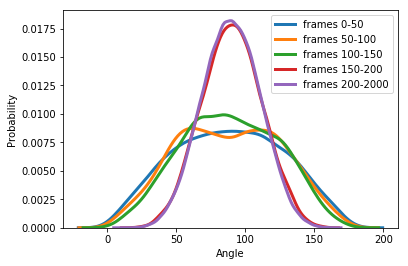

In [63]:
sns.kdeplot(op1, lw=3, label='frames 0-50')
sns.kdeplot(op2, lw=3, label='frames 50-100')
sns.kdeplot(op3, lw=3, label='frames 100-150')
sns.kdeplot(op4, lw=3, label='frames 150-200')
sns.kdeplot(op5, lw=3, label='frames 200-2000')
plt.ylabel('Probability')
plt.xlabel('Angle')
plt.show()

## Eccentricity calculation
We can see from the simulation that we formed a cylindrical fiber. Eccentricity is a way of quantifying how circular the cross-section of fiber is. 

$e = {\sqrt {1-{\frac {b^{2}}{a^{2}}}}}$ where a and b are the lengths of major and minor axes.

We can also write this in terms of moment of inertia:

$e = {\sqrt {1-{\frac {I_b}{I_a}}}}$ where $I_a$ and $I_b$ denote the major and minor axis contribution of the moment of inertia normal to the nanofiber, respectively.

- At eccentricity = 0 we get a circle
- for 0 < eccentricity < 1 we get an ellipse
- for eccentricity = 1 we get a parabola
- for eccentricity > 1 we get a hyperbola
- for infinite eccentricity we get a line



In [80]:
u.trajectory[-1]

< Timestep 2220 with unit cell dimensions [123.633545 123.633545  66.571915  90.        90.        90.      ] >

Use the built-in function to calculate the moments of inertia:

In [81]:
mom_i = poly.moment_of_inertia()

In [82]:
mom_i

array([[12883446.02192124,  -142844.16369139,  -325942.81712093],
       [ -142844.16369139, 12277065.60507563,   533548.63101543],
       [ -325942.81712093,   533548.63101543, 10158974.43793106]])

Find the eigenvalues using `numpy.linalg.eig`:

In [83]:
w, v = LA.eig(mom_i)

In [84]:
w

array([10003951.45209979, 12989223.57245107, 12326311.04037709])

The eigenvalues are returned in random order. We need them to be sorted, from the largest to the smallest:

In [85]:
idx = w.argsort()[::-1] 
w = w[idx]

Finally, use the eigenvalues to calculate the eccentricity:

In [86]:
eccentricity = np.sqrt(1-w[1]/w[0])

In [87]:
eccentricity

0.225910552973468

Now as always put it all into a nice function and iterate over the whole trajectory:

In [78]:
ecc = []
for ts in u.trajectory:
# Calculate eccentricity using moment of inertia
    mom_i = poly.moment_of_inertia()
    w, v = LA.eig(mom_i)
    idx = w.argsort()[::-1]   #we sort the moment of inertia in order from largest to smallest
    w = w[idx]
    #w[0] and w[1] are along x and y, w[2] is along long axis of fiber (z-axis)
    eccentricity = np.sqrt(1-w[1]/w[0])
    ecc.append(eccentricity)

Plot the results:

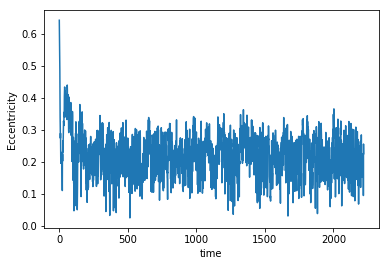

In [79]:
fig, ax = plt.subplots()
ax.plot(ecc)
plt.ylabel('Eccentricity')
plt.xlabel('time')
plt.show()